In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.applications import vgg16
K.set_learning_phase(0)
model =vgg16.VGG16(weights='imagenet', include_top=True)

Using TensorFlow backend.


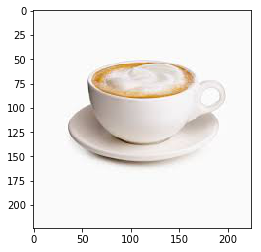

In [2]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
%matplotlib inline
filename = "img.jpg"
org_img = load_img(filename, target_size=(model.input_shape[1], model.input_shape[2]))
plt.imshow(org_img)
plt.show()

In [3]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
nrow = model.input_shape[1]
ncol = model.input_shape[2]
nchan = model.input_shape[3]
batch_shape = (1,nrow,ncol,nchan)
x = np.zeros(batch_shape)
x[0,:,:,:] = org_img

In [4]:
org_pred = model.predict(x)
dec_org_pred = decode_predictions(org_pred)
dec_org_pred


[[('n07930864', 'cup', 0.94683927),
  ('n03937543', 'pill_bottle', 0.0072032143),
  ('n04263257', 'soup_bowl', 0.0052245213),
  ('n04332243', 'strainer', 0.004388819),
  ('n04398044', 'teapot', 0.0039917952)]]

In [5]:
import tensorflow as tf

In [6]:
def FGSM_attack(img, target, step, num_steps, model):
    x = model.inputs[0]
    y = model(x)
    cost = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=target)
    grad, = tf.gradients(cost, x)
    normalized_grad = tf.sign(grad)
    normalized_grad = tf.stop_gradient(normalized_grad)
    adv_x = x - step *  normalized_grad
    adv_x = tf.clip_by_value(adv_x, 0, 255)
    for s in range(0,num_steps):
        print("Step: ",s)
        adv_val = adv_x.eval({x:img})
        c = cost.eval({x:img})
        print("Cost: {}".format(c[0]))
        print("Predicted as: {}".format(decode_predictions(y.eval({x:img}))[0][0]))
        img = adv_val
    return img

In [8]:
import random
t = np.zeros([1,1000])
r = random.randint(0,1000)
t[0,r] = 1
decode_predictions(t)


[[('n07880968', 'burrito', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02317335', 'starfish', 0.0),
  ('n02389026', 'sorrel', 0.0),
  ('n02364673', 'guinea_pig', 0.0)]]

In [ ]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter
from keras.models import Model

nrow = model.input_shape[1]
ncol = model.input_shape[2]
nchan = model.input_shape[3]
batch_shape = (1,nrow,ncol,nchan)
x = np.zeros(batch_shape)
x[0,:,:,:] = org_img
config = model.get_config()
weights = model.get_weights()
new_model = Model.from_config(config)
new_model.set_weights(weights)
print(decode_predictions(model.predict(x)))

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

export_path = 'test'
builder = saved_model_builder.SavedModelBuilder(export_path)

signature = predict_signature_def(inputs={'images': new_model.input},
                                  outputs={'scores': new_model.output})

with K.get_session()as sess:
    builder.add_meta_graph_and_variables(sess=sess,
                                         tags=[tag_constants.SERVING],
                                         signature_def_map={'predict': signature})
# with tf.Session() as sess:
#     sess.run(init_op)
    xn = FGSM_attack(x, t, 1,20, model)
# model.inputs[0]

[[('n07930864', 'cup', 0.94683927), ('n03937543', 'pill_bottle', 0.0072032143), ('n04263257', 'soup_bowl', 0.0052245213), ('n04332243', 'strainer', 0.004388819), ('n04398044', 'teapot', 0.0039917952)]]
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
Step:  0
Cost: 6.909383773803711
Predicted as: ('n07930864', 'cup', 0.94683927)
Step:  1
Cost: 6.908845901489258
Predicted as: ('n03937543', 'pill_bottle', 0.28531685)
Step:  2
Cost: 6.908809661865234
Predicted as: ('n04019541', 'puck', 0.20715472)
Step:  3
Cost: 6.908974647521973
Predicted as: ('n04141975', 'scale', 0.59265608)
Step:  4
Cost: 6.908785820007324
Predicted as: ('n03692522', 'loupe', 0.16385479)
Step:  5
Cost: 6.908774375915527
Predicted as: ('n07930864', 'cup', 0.15554257)
Step:  6
Cost: 6.909101486206055
Predicted as: ('n03887697', 'paper_towel', 0.70451689)
Step:  7
Cost: 6.908744812011719
Predicted as: ('n15075141', 'toilet_tissue', 0.094723426)
Step:  8
Cost: 6.908212661743164
Predicted as: ('n07930

In [ ]:
plt.imshow(array_to_img(xn[0]))
plt.show()
print()
print(org_pred[0,r])
with K.get_session() as sess:
    print(model.predict(xn)[0,r])
    decode_predictions(model.predict(xn))